# Bayesian Variational Autoencoder

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using ForwardDiff

#statistics
using Distributions
using Statistics
using Random
using StatsBase:sample

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. Create data

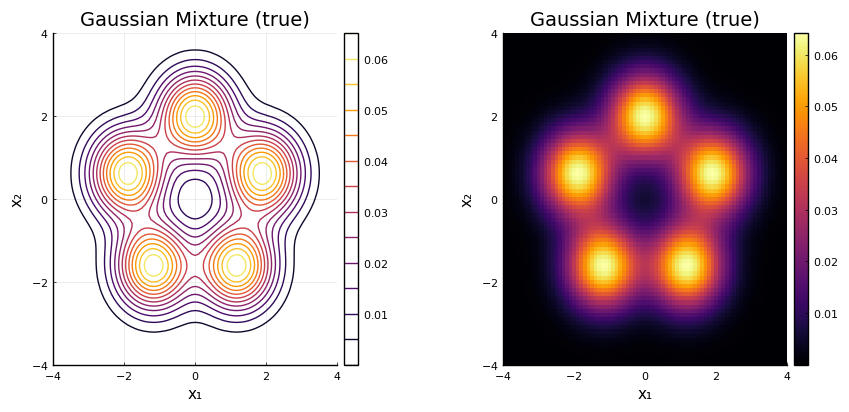

In [2]:
#Gaussian Mixture
trueK = 5
Σ = I(2)/2
ϕ = 2*π/5
μk(k, ϕ) = 2*[cos(π/2+k*ϕ), sin(π/2+k*ϕ)]
mixed_normal = MixtureModel([[MvNormal(μk(k, ϕ), Σ) for k in 1:trueK]...])
true_pdf(x) = pdf(mixed_normal, x)

#data
N = 80
Random.seed!(42)
X = rand(mixed_normal, N)
Dx, N = size(X)
data = (X=X, Dx=Dx, N=N)

L = 4

#visualize
x1s = -L:0.1:L
x2s = -L:0.1:L
p1 = plot(x1s, x2s, (x,y)->true_pdf([x,y]), st=:contour, xlim=[-L,L], ylim=[-L,L], xlabel="x₁", ylabel="x₂")
p2 = plot(x1s, x2s, (x,y)->true_pdf([x,y]), st=:heatmap, xlim=[-L,L], ylim=[-L,L], xlabel="x₁", ylabel="x₂")
fig1 = plot(p1, p2, title="Gaussian Mixture (true)", size=(900, 400))
savefig(fig1, "figs-BVAE/fig1.png")

## 2. Gibbs sampler

In [3]:
#model
pmodel(x, μs, λs, πs, K) = pdf(MixtureModel([[MvNormal(μs[:,k],1/√(λs[k])) for k in 1:K]...], πs), x)

#predictive
function ppred(x, param_samps, K)
    @unpack μsamps, λsamps, πsamps = param_samps
    K,S = size(πsamps)
    preds = zeros(S)
    for s in 1:S
        preds[s] = pmodel(x, μsamps[:,:,s], λsamps[:,s], πsamps[:,s], K)
    end
    return mean(preds)
end

#categorical
function rand_ctgr(prob)
    K = length(prob)
    zvec = zeros(K)
    zvec[rand(Categorical(prob))] = 1
    return zvec
end

#update
function updateμk(X, zks, λk, ρ, D, cnt)
    μmean = X*zks/(ρ+cnt)
    μstd = 1/sqrt((λk*(ρ+cnt)))
    return rand(MvNormal(μmean, μstd))
end
function updateλk(X, zks, μkvec, ρ, N, D, cnt)
    λkα = D*(1+cnt)/2 + 1
    λkβ = β + ρ*norm(μkvec)^2/2 + dot(sum((X-μkvec*ones(N)').^2, dims=1), zks)/2
    return rand(Gamma(λkα, 1/λkβ))
end
function update_prob(xn, μvec, λ, π, D, K)
    probs = zeros(K)
    for k in 1:K
        probs[k] = exp(-λ[k]*norm(xn-μvec[:,k])^2/2 + D*log(λ[k])/2 + log(π[k]))
    end
    return probs/sum(probs)
end
updateπ(αvec, cnts) = rand(Dirichlet(αvec + cnts))

function Gibbs_sampler(n_samps, n_burnin, data, model_params, inits)
    #initialize
    @unpack X,Dx,N = data
    @unpack β,ρ,αvec,K = model_params
    @unpack Zs₀,μs₀,λs₀,πs₀ = inits
    Zsamps = zeros(K,N)
    μsamps = zeros(Dx,K,n_samps)
    λsamps = zeros(K,n_samps)
    πsamps = zeros(K,n_samps)
    Zsamps = Zs₀
    μsamps[:,:,1] = μs₀
    λsamps[:,1] = λs₀
    πsamps[:,1] = πs₀
    Zprob = zeros(K,N)
    cnts = sum(Zsamps, dims=2)[:]
    @showprogress for s in 2:n_samps
        for k in 1:K
            μsamps[:,k,s] = updateμk(X, Zsamps[k,:], λsamps[k,s-1], ρ, Dx, cnts[k])
            λsamps[k,s] = updateλk(X, Zsamps[k,:], μsamps[:,k,s], ρ, N, Dx, cnts[k])
        end
        πsamps[:,s] = updateπ(αvec, cnts)
        for n in 1:N
            Zprob[:,n] = update_prob(X[:,n], μsamps[:,:,s], λsamps[:,s], πsamps[:,s], Dx, K)
            Zsamps[:,n] = rand_ctgr(Zprob[:,n])
        end
        cnts = sum(Zsamps, dims=2)[:]
    end
    return Zsamps, μsamps[:,:,n_burnin:end], λsamps[:,n_burnin:end], πsamps[:,n_burnin:end]
end

Gibbs_sampler (generic function with 1 method)

In [4]:
#parameters
β = 1
ρ = 1
K = 3
αvec = ones(K)
model_params = (β=β, ρ=ρ, αvec=αvec, K=K)

#initialize
πs₀ = rand(Dirichlet(αvec))
Zs₀ = zeros(K,N)
for n in 1:N
    Zs₀[:,n] = rand_ctgr(πs₀)
end
μs₀ = zeros(Dx,K)
λs₀ = ones(K)
inits = (Zs₀=Zs₀, μs₀=μs₀, λs₀=λs₀, πs₀=πs₀)

#sample
n_samps = 5000
n_burnin = div(n_samps, 10)
Zsamps, μsamps, λsamps, πsamps = Gibbs_sampler(n_samps, n_burnin, data, model_params, inits)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


([1.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 1.0 0.0], [-0.27260748511006233 1.6358194454779484 -1.4124548729465878; -0.3597729620165539 0.6922505841954937 0.3998896896313856]

[-0.550511488038602 1.258723083191768 -1.6184038280810986; -0.6763179530918272 0.8220844493614813 0.3771120906920382]

[-0.7188205834880047 1.7864609111885639 -1.6203695578827904; -0.5062886162552064 1.0981540577052185 0.21387626482693184]

...

[-0.6148919648849801 1.2753363189960605 2.0052540630688505; -0.36232450803434424 -1.1451638285792654 0.5273571949447512]

[-0.690128961564843 0.7458894269613854 2.0713593068115026; 0.06227117392396449 -0.9141364659616059 0.6537499401961743]

[-1.3846540323137722 1.0079602681038071 2.4472972861473288; 0.13391765978404796 -0.9130987394899829 0.37945499855938103], [0.400004088570183 0.4529217387556993 … 0.4276934514508714 0.452933034793531; 1.482392979015912 1.2065287663602269 … 0.6769696410564296 0.66186928872192; 1.4147259179388953 1.4802246493495532 … 1.502873777240

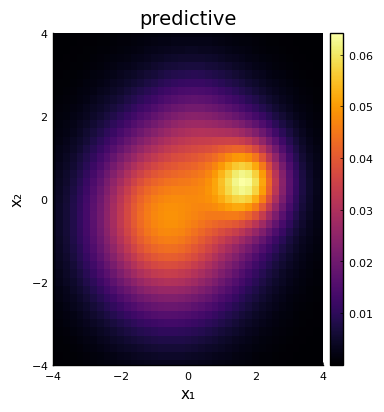

In [5]:
#show the result
samps = (μsamps=μsamps, λsamps=λsamps, πsamps=πsamps)
x1s = -L:0.2:L
x2s = -L:0.2:L
fig2 = plot(x1s, x2s, (x,y)->ppred([x,y], samps, K), st=:heatmap, xlim=[-L,L], ylim=[-L,L], xlabel="x₁", ylabel="x₂", title="predictive", size=(400,400))
savefig(fig2, "figs-BVAE/fig2.png")

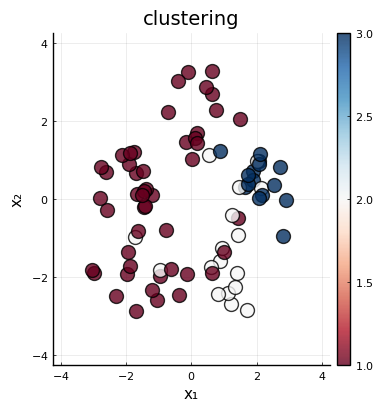

In [6]:
Zs = sum(collect(1:K) .* Zsamps, dims=1)[:]
fig3 = plot(xlabel="x₁", ylabel="x₂", title="clustering", label=false, size=(400,400), legend=false)
plot!(X[1,:], X[2,:], zcolor=Zs, st=:scatter, c=:RdBu, colorbar=:true, xlim=[-L,L], ylim=[-L,L], markersize=10, alpha=0.8)
savefig(fig3, "figs-BVAE/fig3.png")

## 3. Variational Autoencoder

In [7]:
#initialize the parameter
function init_params(st)
    @unpack  DI, DO, DM = st
    W₂ = randn(DM, DI)
    W₃ = randn(DO, DM)
    b₂ = zeros(DM)
    b₃ = zeros(DO)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  DI, DO, DM = st
    W = reshape(wvec, (DI+DO+1, DM+1))
    W₂ = view(W, 2:DI+1, 1:DM)'
    W₃ = view(W, DI+2:DI+DO+1, 1:DM)
    b₂ = view(W, 1, 1:DM)
    b₃ = view(W, DI+2:DI+DO+1, DM+1)
    return W₂, W₃, b₂, b₃
end 

#Neural Network
function nn(x, wvec, st)
   @unpack  DI, DO, DM = st
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return W₃*tanh.(W₂*x+b₂) + b₃
end

nn (generic function with 1 method)

In [8]:
#encoder and decoder 
Φ(zn, wvec, stΦ) = nn(zn, wvec, stΦ)
Ψ(xn, ηvec, stΨ) = nn(xn, ηvec, stΨ)

#zn mean and logstd, std
function mean_and_logstd(vecn, pvec, D, st)
    tmp = nn(vecn, pvec, st)
    tmp[1:D], tmp[D+1:end]
end

function mean_and_std(vecn, pvec, D, st)
    mvec, logsvec = mean_and_logstd(vecn, pvec, D, st)
    mvec, exp.(logsvec)
end

#used for reparameterization trick
g(ϵvec, θvec) = θvec[1:dw] + exp.(θvec[dw+1:end]) .* ϵvec
function h(ϵvec, ηvec, xn, Dz, stΨ)
    mvec, svec = mean_and_std(xn, ηvec, Dz, stΨ)
    mvec + svec .* ϵvec
end

#logpmodel 
function logpmodel(xn, zn, wvec, Dx, stΦ)
    uvec, vvec = mean_and_std(zn, wvec, Dx, stΦ)
    logpdf(MvNormal(uvec, ones(Dx)), xn)
end
logpmodel(xn,ϵwvec,ϵzvec,θvec,ηvec,Dx,Dz,stΦ,stΨ)=logpmodel(xn,h(ϵzvec,ηvec,xn,Dz,stΨ),g(ϵwvec,θvec),Dx,stΦ)

#used for calculation of ELBO
function fz(xn, ηvec, Dz, stΨ)
    mvec, logsvec = mean_and_logstd(xn, ηvec, Dz, stΨ)
    Dz/2 + sum(logsvec) - (norm(mvec)^2 + norm(exp.(logsvec))^2)/2
end
fw(θvec,λw,dw)=dw/2*(1+log(λw))-λw*(norm(θvec[1:dw])^2+norm(exp.(θvec[dw+1:end]))^2)/2+sum(θvec[dw+1:end])

#ELBO
function ELBO(X, θvec, ηvec, ϵwsamps, ϵzsamps, λw, dw, N, Dx, Dz, S, stΦ, stΨ)
    logpmodels = zeros(S)
    sumvec = zeros(N)
    for n in 1:N
        for s in 1:S
            logpmodels[s] = logpmodel(X[:,n], ϵwsamps[:,s], ϵzsamps[:,s], θvec, ηvec, Dx, Dz, stΦ, stΨ)
        end
        sumvec[n] = mean(logpmodels) + fz(X[:,n], ηvec, Dz, stΨ)
    end
    sum(sumvec) + fw(θvec, λw, dw)
end

#approximation of ELBO Ln
ELBO(xn,θvec,ηvec,ϵwvec,ϵzvec,Dx,Dz,stΦ,stΨ) = logpmodel(xn,ϵwvec,ϵzvec,θvec,ηvec,Dx,Dz,stΦ,stΨ)

#gradient of ELBO w.r.t θ and η
function ∇θLn(X, minibatch_size, Midx, N, θvec, ηvec, ϵwsamp, ϵzsamp, λw, dw, Dx, Dz, stΦ, stΨ)
    ∇θint = zeros(2*dw, minibatch_size)
    for m in 1:minibatch_size
        ∇θint[:,m] = ForwardDiff.gradient(vec->logpmodel(
                X[:,Midx[m]],ϵwsamp,ϵzsamp,vec,ηvec,Dx,Dz,stΦ,stΨ),θvec
        )
    end
    N*mean(∇θint, dims=2) + ForwardDiff.gradient(vec->fw(vec, λw, dw), θvec)
end

function ∇ηLn(X, minibatch_size, Midx, N, θvec, ηvec, ϵwsamp, ϵzsamp, λw, dw, Dx, Dz, stΦ, stΨ)
    ∇ηLnvec = zeros(dη, minibatch_size)
    for m in 1:minibatch_size
        ∇ηLnvec[:,m] = ForwardDiff.gradient(vec->(
                logpmodel(X[:,Midx[m]],ϵwsamp,ϵzsamp,θvec,vec,Dx,Dz,stΦ,stΨ)+fz(X[:,Midx[m]],vec,Dz,stΨ)
                ),ηvec)
    end
    N*mean(∇ηLnvec, dims=2)
end

#variational infernce
function myVI(data, model_params, n_train, minibatch_size, α, ϵ)
    #initalize and set the parameters
    @unpack X,Dx,N = data
    @unpack λw,dw,dη,Dz,stΦ,stΨ,ηvec₀ = model_params
    θvec = vcat(zeros(dw), ones(dw))
    ηvec = ηvec₀
    
    #minibatch
    Midx = zeros(minibatch_size)
    
    #AdaGrad
    δ = 1e-7
    gθvec = zeros(2*dw)
    gηvec = zeros(dη)
    rθvec = δ * ones(2*dw)
    rηvec = δ * ones(dη)
    
    #ELBO
    S = 100
    ϵwsamps = rand(MvNormal(zeros(dw), ones(dw)), S)
    ϵzsamps = rand(MvNormal(zeros(Dz), ones(Dz)), S)
    history = zeros(n_train)
    history[1] = ELBO(X, θvec, ηvec, ϵwsamps, ϵzsamps, λw, dw, N, Dx, Dz, S, stΦ, stΨ)
    @showprogress for k in 2:n_train
        #choose mini batch
        Midx = sample(1:N, minibatch_size, replace=false)
        
        #update(AdaGrad)
        ϵwsamps = rand(MvNormal(zeros(dw), ones(dw)), S)
        ϵzsamps = rand(MvNormal(zeros(Dz), ones(Dz)), S)
        gθvec = ∇θLn(X,minibatch_size,Midx,N,θvec,ηvec,ϵwsamps[:,1],ϵzsamps[:,1],λw,dw,Dx,Dz,stΦ,stΨ)
        gηvec = ∇ηLn(X,minibatch_size,Midx,N,θvec,ηvec,ϵwsamps[:,1],ϵzsamps[:,1],λw,dw,Dx,Dz,stΦ,stΨ)
        rθvec = rθvec + gθvec .* gθvec
        rηvec = rηvec + gηvec .* gηvec
        θvec += α * gθvec ./ sqrt.(rθvec)
        ηvec += α * gηvec ./ sqrt.(rηvec)
        
        #calculate ELBO
        history[k] = ELBO(X, θvec, ηvec, ϵwsamps, ϵzsamps, λw, dw, N, Dx, Dz, S, stΦ, stΨ)
        if abs(history[k]-history[k-1])<ϵ
            return θvec, ηvec, history[1:k]
            break
        end
    end
    return θvec, ηvec, history
end

myVI (generic function with 1 method)

In [9]:
#set the random seed
Random.seed!(42)

#latent dimension
Dz = 1

#initialize Neural Network (decoder)
DΦ = 5
stΦ = (DI=Dz, DO=2*Dx, DM=DΦ)
WΦ₂, WΦ₃, bΦ₂, bΦ₃ = init_params(stΦ)
WΦs = stick_params(WΦ₂, WΦ₃, bΦ₂, bΦ₃, stΦ.DI)
wvec₀ = WΦs[:]
dw = length(wvec₀)

#initialize Neural Network (encoder)
DΨ = 5
stΨ = (DI=Dx, DO=2*Dz, DM=DΨ)
WΨ₂, WΨ₃, bΨ₂, bΨ₃ = init_params(stΨ)
WΨs = stick_params(WΨ₂, WΨ₃, bΨ₂, bΨ₃, stΨ.DI)
ηvec₀ = WΨs[:]
dη = length(ηvec₀)

#model parameters
λw = 1
model_params = (λw=λw, dw=dw, dη=dη, Dz=Dz, stΦ=stΦ, stΨ=stΨ, ηvec₀)

#variational inference
n_train = 1000
α = 0.01
ϵ = 1e-3
minibatch_size = 1
@time θvec, ηvec, history = myVI(data, model_params, n_train, minibatch_size, α, ϵ)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


 45.342322 seconds (364.24 M allocations: 37.790 GiB, 12.89% gc time)


([-0.006261901791666196; -0.020701801077927084; … ; 0.5157185119922101; 0.5157185119922101], [-0.16374014191656683; 0.5452950383938096; … ; 0.007958874361823938; -0.12382248987921964], [-21538.49850264793, -18596.206504504717, -18541.67986415647, -15910.43214998983, -16337.294187886808, -16343.631552421724, -16364.915393708978, -16380.143805110487, -14969.461903734507, -15246.508156979378  …  -4436.587281977573, -4445.742512104351, -4322.21341392645, -4627.107275324652, -4383.213189370953, -4168.76080494471, -4099.5914563061615, -4212.925403306711, -4838.132877976558, -4211.243773001634])

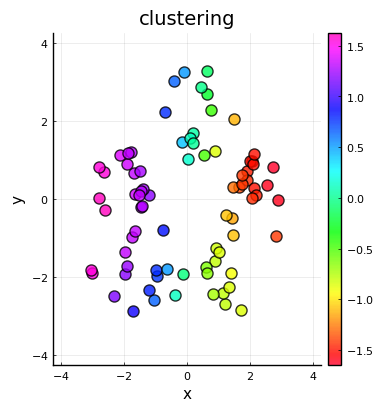

In [10]:
Zs = zeros(N)
for n in 1:N
    Zs[n] = Ψ(X[:,n], ηvec, stΨ)[1]
end
fig4 = plot(xlim=[-L,L], ylim=[-L,L], xlabel="x", ylabel="y", title="clustering", size=(400,400))
plot!(X[1,:], X[2,:], zcolor=Zs, st=:scatter, c=palette(:gist_rainbow), markersize=8, alpha=0.8, label=false)
savefig(fig4, "figs-BVAE/fig4.png")

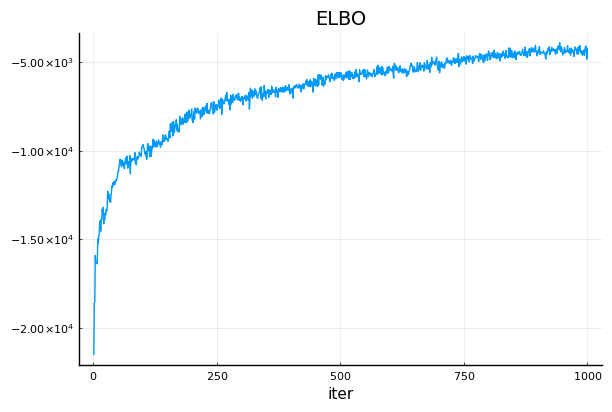

In [11]:
fig5 = plot(history, xlabel="iter", title="ELBO", label=false)
savefig(fig5, "figs-BVAE/fig5.png")